# Cell type annotation prediction

Run this notebook on google colab to use a free GPU!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/helicalAI/helical/blob/main/examples/notebooks/Cell-Type-Annotation.ipynb)

In this notebook, an [scGPT](https://www.nature.com/articles/s41592-024-02201-0) model is used to predict a cell type annotation with a given gene expression profile.

This follows the tutorial from scGPT [here](https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Annotation.ipynb), but instead of fine-tuning the entire model, a smaller neural network is trained, using the embeddings of the gene expressions as inputs, to make a prediction.

The same approach is made with the [Geneformer](https://www.nature.com/articles/s41586-023-06139-9.epdf?sharing_token=u_5LUGVkd3A8zR-f73lU59RgN0jAjWel9jnR3ZoTv0N2UB4yyXENUK50s6uqjXH69sDxh4Z3J4plYCKlVME-W2WSuRiS96vx6t5ex2-krVDS46JkoVvAvJyWtYXIyj74pDWn_DutZq1oAlDaxfvBpUfSKDdBPJ8SKlTId8uT47M%3D) model and the results are compared against each other.

This approach greatly reduces time and complexity.

In [1]:
# !pip install helical

In [2]:
# !pip install datasets --upgrade

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
import anndata as ad
import torch
from scipy.sparse import lil_matrix

2024-08-09 14:11:44.935639: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 14:11:44.945189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 14:11:44.954598: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 14:11:44.957448: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 14:11:44.965607: I tensorflow/core/platform/cpu_feature_guar

In [4]:
## Numa Node Issue https://github.com/tensorflow/tensorflow/issues/42738
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2024-08-09 14:11:47.385743: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46475 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
from helical.models.scgpt.model import scGPT, scGPTConfig
from helical.models.geneformer.model import Geneformer, GeneformerConfig

/home/benoit/miniconda3/envs/helical-package/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/benoit/Documents/helical/helical/models/scgpt/model_dir/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


We load the our dataset from the EMBL [website](https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-11673). To download the dataset, we are leveraging Huggingface's optimized library!

In [6]:
from datasets import load_dataset
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, split="train[:65%]",download_mode="reuse_cache_if_exists")

Generating train split: 100%|██████████| 31680/31680 [00:08<00:00, 3919.09 examples/s]


In [7]:
observation_columns = [obs for obs in list(ds.features.keys()) if not obs == 'raw_counts']
obs_data = pd.DataFrame(ds.select_columns(observation_columns).data.to_pandas(),columns=observation_columns)
lil = lil_matrix((len(ds),ds[0]['size']))
lil.data = np.array(ds['raw_counts'],dtype="object")
lil.rows = np.array(ds['rows'],dtype="object")
adata = ad.AnnData(lil.tocsr(),obs=obs_data)
adata.var_names = ds.features['raw_counts'].id.split(",")
adata.var['gene_name'] = adata.var_names.str.upper()

/home/benoit/miniconda3/envs/helical-package/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Let's familiarise ourselves with the data!

We are interested in the names of the cells we want to predict. They are saved in `adata.obs["LVL1"]`.

Additionally, we need to know how many distinct cell types/classes we have.

In [8]:
# get labels: the celltype
num_types = adata.obs["LVL1"].unique().shape[0]
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))

celltypes_labels = np.array(adata.obs["LVL1"].tolist())

This is all summarized in this dictionary:

In [9]:
id2type

{0: 'ERYTHROID',
 1: 'LYMPHOID',
 2: 'MK',
 3: 'MYELOID',
 4: 'PROGENITOR',
 5: 'STROMA'}

Use the Helical package to get the embeddings of the gene expression profile.

The only thing we need to specify is the column containing the names of the genes. (`gene_name` in this case)

The resulting embeddings are the input features `x` for our smaller NN model.

# scGPT

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)
data = scgpt.process_data(adata, gene_names = "gene_name")
x_scgpt = scgpt.get_embeddings(data)
x_scgpt.shape

INFO:helical.services.downloader:File: '/home/benoit/.cache/helical/models/scgpt/scGPT_CP/vocab.json' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.services.downloader:File saved to: '/home/benoit/.cache/helical/models/scgpt/scGPT_CP/vocab.json'
INFO:helical.services.downloader:File: '/home/benoit/.cache/helical/models/scgpt/scGPT_CP/best_model.pt' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.services.downloader:File saved to: '/home/benoit/.cache/helical/models/scgpt/scGPT_CP/best_model.pt'
INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:
Embedding cells: 100%|██████████| 412/412 [00:41<00:00,  9.93it/s]


(20592, 512)

With the input features, we also need the corresponding labels `y`.

They correspond to the cell type labels.

As we have a categorical prediction, we one-hot-encode the 6 different cell type labels.

In [11]:
y = celltypes_labels
num_classes = num_types

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded, num_classes=num_classes)
y_encoded.shape

(20592, 6)

## Define and train the model

In [12]:
input_shape = (512,)

# define the model
head_model = Sequential()
head_model.add(Dense(128, activation='relu', input_shape=input_shape))
head_model.add(Dropout(0.4))
head_model.add(Dense(32, activation='relu'))
head_model.add(Dropout(0.4))
head_model.add(Dense(num_classes, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
head_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
head_model.summary()

/home/benoit/miniconda3/envs/helical-package/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,990 (273.40 KB)

 Trainable params: 69,990 (273.40 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
head_model_scgpt = head_model
X_train, X_test, y_train, y_test = train_test_split(x_scgpt, y_encoded, test_size=0.1, random_state=42)

# Setup callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = head_model_scgpt.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/50


I0000 00:00:1723205565.685315  165644 service.cc:146] XLA service 0x7d3ca0003720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723205565.685342  165644 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-08-09 14:12:45.699059: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-09 14:12:45.754250: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


288/290 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 0.6884

I0000 00:00:1723205566.456069  165644 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6846 - val_loss: 0.0759
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 0.0992 - val_loss: 0.0686
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 0.0738 - val_loss: 0.0596
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 0.0693 - val_loss: 0.0542
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 0.0662 - val_loss: 0.0522
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 0.0600 - val_loss: 0.0500
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 0.0571 - val_loss: 0.0480
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 0.0514 - val_loss: 0.0474
Epoch 9/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 0.0476 - val_loss: 0.0437
Epoch 10/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 0.0506 - val_loss: 0.0435
Epoch 11/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0521 - val_loss: 0.0489
Epoch 12/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s

In [14]:
predictions_nn = head_model_scgpt.predict(X_test)
y_pred = np.argmax(predictions_nn, axis=1)
y_true = np.argmax(y_test, axis=1)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


## Present the results
- on the test set and,
- a separate, unseen evaluation set

In [15]:
def get_evaluations(name_data_set, y_true, y_pred) -> dict:
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  print(f"{name_data_set} accuracy: {(accuracy*100):.1f}%")
  print(f"{name_data_set} precision: {(precision*100):.1f}%")
  print(f"{name_data_set} f1: {(f1*100):.1f}%")
  print(f"{name_data_set} recall: {(recall*100):.1f}%")
  return {
      "accuracy": accuracy,
      "precision": precision,
      "f1": f1,
      "recall": recall,
  }

In [16]:
get_evaluations("Test set", y_true, y_pred)

Test set accuracy: 98.9%
Test set precision: 89.5%
Test set f1: 88.8%
Test set recall: 88.8%


{'accuracy': 0.9893203883495145,
 'precision': 0.8946466960543131,
 'f1': 0.8880255766301796,
 'recall': 0.8875827658685017}

Load the unseen evaluation set:

In [17]:
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, split="train[70%:]",download_mode="reuse_cache_if_exists")

Generating train split: 100%|██████████| 31680/31680 [00:07<00:00, 4202.76 examples/s]


In [18]:
observation_columns = [obs for obs in list(ds.features.keys()) if not obs == 'raw_counts']
obs_data = pd.DataFrame(ds.select_columns(observation_columns).data.to_pandas(),columns=observation_columns)
lil = lil_matrix((len(ds),ds[0]['size']))
lil.data = np.array(ds['raw_counts'],dtype="object")
lil.rows = np.array(ds['rows'],dtype="object")
adata = ad.AnnData(lil.tocsr(),obs=obs_data)
adata.var_names = ds.features['raw_counts'].id.split(",")
adata.var['gene_name'] = adata.var_names.str.upper()

/home/benoit/miniconda3/envs/helical-package/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [19]:
data_unseen = scgpt.process_data(adata_unseen, gene_names="gene_name")
x_unseen = scgpt.get_embeddings(data_unseen)
predictions_nn_unseen = head_model_scgpt.predict(x_unseen)

INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:
Embedding cells: 100%|██████████| 191/191 [00:19<00:00,  9.77it/s]

  1/297 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


We should double check that the cell types are mapped to the correct id numbers for both the training data and this new data set.

In [20]:
num_types = adata_unseen.obs["LVL1"].unique().shape[0]
id2type_unseen = dict(enumerate(adata_unseen.obs["LVL1"].astype("category").cat.categories))
id2type_unseen == id2type

True

In [21]:
y_true_unseen = np.array(adata_unseen.obs["LVL1"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.argmax(predictions_nn_unseen, axis=1)]

scgpt_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 99.2%
Evaluation set precision: 84.8%
Evaluation set f1: 85.6%
Evaluation set recall: 87.3%


Plot a confusion matrix to visualise the classification performance for each the cell type. This is done for the evalation set.

<Axes: >

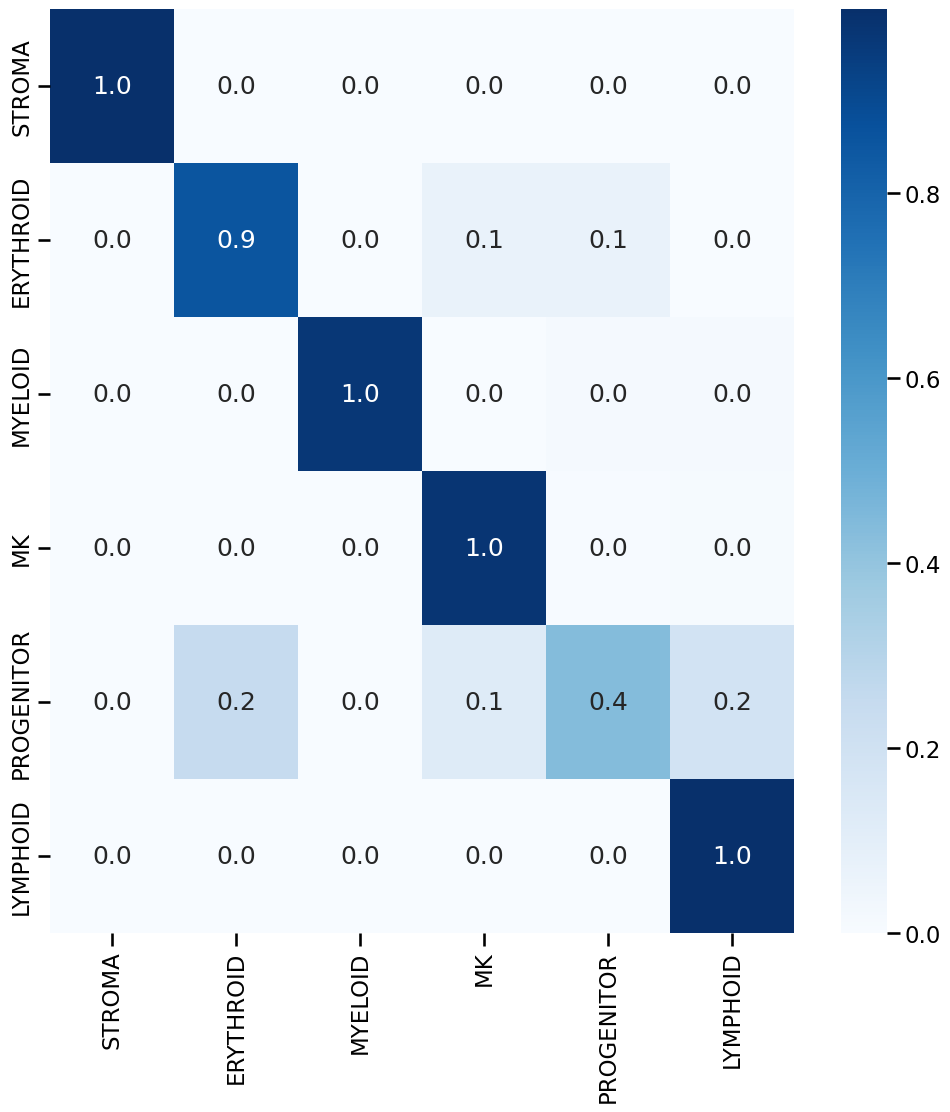

In [22]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

set_predicted_cell_types = list(adata_unseen.obs["LVL1"].unique())
for i in set(y_pred_unseen):
    if i not in set_predicted_cell_types:
        set_predicted_cell_types.remove(i)

cm = confusion_matrix(y_true_unseen, y_pred_unseen)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=set_predicted_cell_types[:cm.shape[0]], columns=set_predicted_cell_types[:cm.shape[1]])
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")

# Geneformer

Let's do the same with the Geneformer.

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

geneformer_config = GeneformerConfig(batch_size=50, device=device)
geneformer = Geneformer(configurer = geneformer_config)

data_geneformer = geneformer.process_data(adata, gene_names = "gene_name")
x_geneformer = geneformer.get_embeddings(data_geneformer)
x_geneformer.shape

INFO:helical.services.downloader:File: '/home/benoit/.cache/helical/models/geneformer/gene_median_dictionary.pkl' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.services.downloader:File saved to: '/home/benoit/.cache/helical/models/geneformer/gene_median_dictionary.pkl'
INFO:helical.services.downloader:File: '/home/benoit/.cache/helical/models/geneformer/token_dictionary.pkl' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.services.downloader:File saved to: '/home/benoit/.cache/helical/models/geneformer/token_dictionary.pkl'
INFO:helical.services.downloader:File: '/home/benoit/.cache/helical/models/geneformer/geneformer-12L-30M/config.json' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.services.downloader:File saved to: '/home/benoit/.cache/helical/models/geneformer/geneformer-12L-30M/config.json'
INFO:helical.services.downloader:File: '/home/benoit/.cache/helical/models/geneformer/genefo

(20592, 512)

In [24]:
head_model_geneformer = head_model
X_train, X_test, y_train, y_test = train_test_split(x_geneformer, y_encoded, test_size=0.1, random_state=42)

# Setup callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = head_model_geneformer.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 2.1091 - val_loss: 0.0985
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 0.1353 - val_loss: 0.0690
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 0.0973 - val_loss: 0.0597
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 0.0840 - val_loss: 0.0527
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.0764 - val_loss: 0.0508
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 0.0685 - val_loss: 0.0515
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 0.0654 - val_loss: 0.0442
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.0694 - val_loss: 0.0432
Epoch 9/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 0.0630 - val_loss: 0.0427
Epoch 10/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.0531 - val_loss: 0.0407
Epoch 11/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.0560 - val_loss: 0.0399
Epoch 12/50
290/290 ━━━━━━━━━━

In [25]:
# %tensorboard --logdir logs/fit # uncomment to use tensorboard

In [26]:
data_unseen_geneformer = geneformer.process_data(adata_unseen, gene_names = "gene_name")
x_unseen_geneformer = geneformer.get_embeddings(data_unseen_geneformer)
predictions_nn_unseen_geneformer = head_model_geneformer.predict(x_unseen_geneformer)

INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/benoit/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/benoit/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/benoit/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.services.mapping:Mapped 21111 genes to Ensembl IDs from a total of 37318 genes.
/home/benoit/Documents/helical/helical/models/geneformer/geneformer_tokenizer.py:366: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  filter_pass_loc = np.where(adata.obs.get("filter_pass", 0) == 1)[0]
INFO:helical.models.geneformer.geneformer_tokenizer:A

142/297 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


In [27]:
y_true_unseen = np.array(adata_unseen.obs["LVL1"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.argmax(predictions_nn_unseen_geneformer, axis=1)]

geneformer_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 99.0%
Evaluation set precision: 79.2%
Evaluation set f1: 78.1%
Evaluation set recall: 77.8%


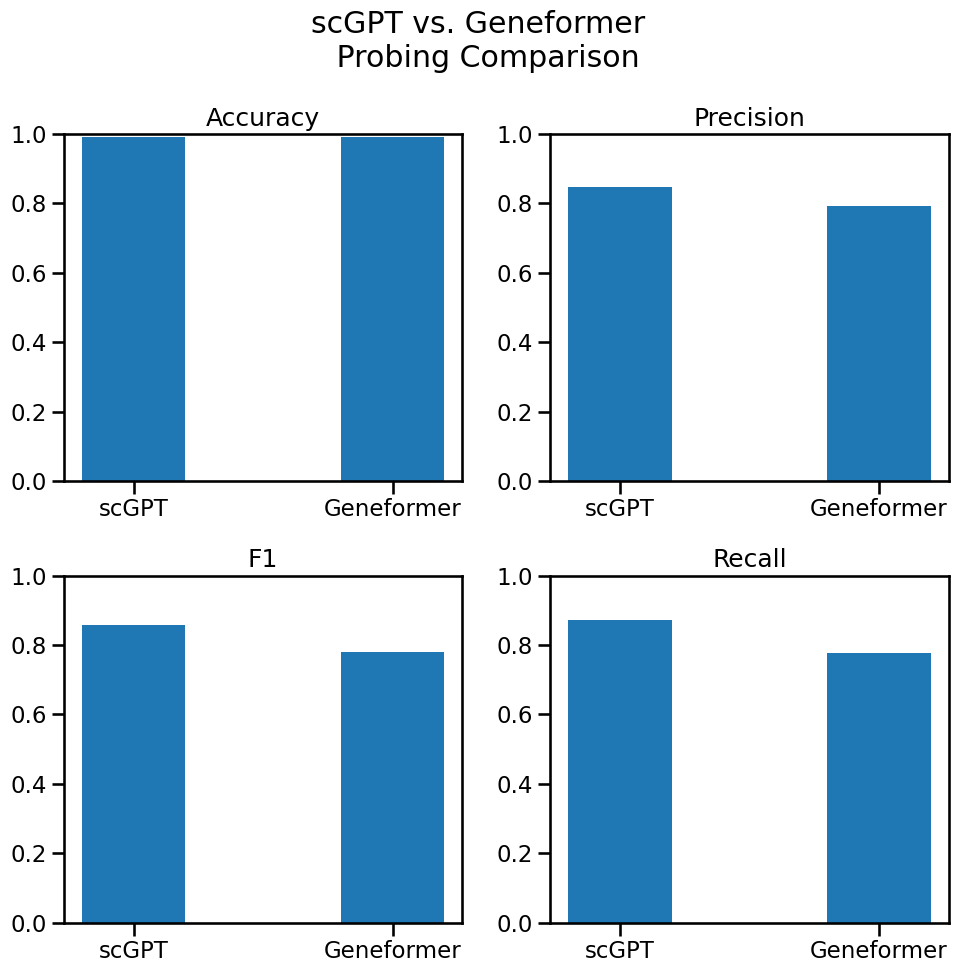

In [28]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

values_1 = [scgpt_results["accuracy"], geneformer_results["accuracy"]]
x = ["scGPT", "Geneformer"]
axs[0, 0].bar(x, values_1, width=0.4)
axs[0, 0].set_title("Accuracy")
axs[0, 0].set_ylim([0, 1])

values_2 = [scgpt_results["precision"], geneformer_results["precision"]]
axs[0, 1].bar(x, values_2, width=0.4)
axs[0, 1].set_title("Precision")
axs[0, 1].set_ylim([0, 1])

values_3 = [scgpt_results["f1"], geneformer_results["f1"]]
axs[1, 0].bar(x, values_3, width=0.4)
axs[1, 0].set_title("F1")
axs[1, 0].set_ylim([0, 1])

values_4 = [scgpt_results["recall"], geneformer_results["recall"]]
axs[1, 1].bar(x, values_4, width=0.4)
axs[1, 1].set_title("Recall")
axs[1, 1].set_ylim([0, 1])

fig.suptitle("scGPT vs. Geneformer \n Probing Comparison")
fig.tight_layout()
plt.show()



## scGPT
- Accuracy: 99.2%
- Precision: 84.8%
- Recall: 85.6%
- Macro F1: 87.3%

## Geneformer
- Accuracy: 99.0%
- Precision: 79.2%
- Recall: 78.1%
- Macro F1: 77.8%

 (c) Helical 2024 - Developed by the Helical Team